In [24]:
import pandas as pd
import numpy as np
import math
import timeit
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
import os
import platform
import pickle
from subprocess import check_output
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (precision_score, recall_score, 
                             roc_auc_score, f1_score, 
                             plot_confusion_matrix, ConfusionMatrixDisplay, roc_curve)

%matplotlib inline

In [25]:
pwd


'/content/drive/My Drive/UofT/Fall 21/Courses/CSC2515/CSC2515 Project'

In [26]:
# Change to the directory containing files downloaded from https://www.cs.toronto.edu/~kriz/cifar.html
#cd ....

/content/drive/MyDrive/UofT/Fall 21/Courses/CSC2515/CSC2515 Project


## Data Preprocessing  

In [27]:
def load_label_names(ROOT):
  file = os.path.join(ROOT, 'batches.meta')
  with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin-1')
  label_names=dict['label_names']
  return label_names

In [45]:
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)
def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

def load_CIFAR10(ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte

def get_CIFAR10_data(num_training=20000, num_validation=8500, num_test=10000, valid=False):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cifar-10-batches-py/'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    if valid == False:
      X_train = X_train.astype('float32')
      X_test = X_test.astype('float32')

      X_train /= 255
      X_test /= 255
      return X_train, y_train, X_test, y_test

    else:
      # Subsample the data
      mask = range(X_train.shape[0]-num_validation, X_train.shape[0])
      X_val = X_train[mask]
      y_val = y_train[mask]
      mask = range(num_training)
      X_train = X_train[mask]
      y_train = y_train[mask]
      mask = range(num_test)
      X_test = X_test[mask]
      y_test = y_test[mask]

      X_train = X_train.astype('float32')
      X_test = X_test.astype('float32')

      X_train /= 255
      X_test /= 255
      return X_train, y_train, X_val, y_val, X_test, y_test

AdaBoost Classifier

In [52]:
def AB_Classifier(train_data, train_labels, test_data, test_labels):
  model_cv = AdaBoostClassifier(base_estimator = DecisionTreeClassifier())

  # Training AdaBoost
  start = timeit.default_timer()
  model_cv.fit(train_data, train_labels)
  stop = timeit.default_timer()
  print('Training Time:', stop-start)

  # Prediction using AdaBoost
  start = timeit.default_timer()
  y_pred = model_cv.predict(test_data)
  stop = timeit.default_timer()
  print('Inference Time:', stop-start)
  # print("Prediction Probability:",model_cv.predict_proba(test_data))
  eval_metrics(test_labels, y_pred, pred_prob=model_cv.predict_proba(test_data))
  plot_confusion_matrix(model_cv, test_data, test_labels)
  plt.show()  


Evaluating

In [53]:
def eval_metrics(true, pred, pred_prob=None):
  
    print("Accuracy:",(true==pred).mean())
    print("Precision:", precision_score(true, pred, average='macro'))
    print("Recall:", recall_score(true, pred, average='macro'))
    print("f1:", f1_score(true, pred, average='macro'))


In [54]:
 def eval_loss(train_losses, test_losses):

   plt.plot(train_losses, label= "Training loss")
   plt.plot(test_losses, label= "Test loss")
   plt.legend()


In [55]:
 def eval_accuracy( train_correct, test_correct):

   train_accuracy =[t/500 for t in train_correct ] 
   test_accuracy =[t/100 for t in test_correct ] 
   plt.plot(train_accuracy, label= "Training accuracy")
   plt.plot(test_accuracy, label= "Test accuracy")
   plt.legend()

## Main Method

In [56]:
def main():
  # Invoke the above function to get our data.
  x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data(valid=True)

  # Loading label names
  label_names = load_label_names('cifar-10-batches-py/')

  print('\nTrain data shape: ', x_train.shape)
  print('Train labels shape: ', y_train.shape)
  print('Validation data shape: ', x_val.shape)
  print('Validation labels shape: ', y_val.shape)
  print('Test data shape: ', x_test.shape)
  print('Test labels shape: ', y_test.shape)

  # AdaBoost Classifier
  AB_Classifier(x_train, y_train, x_test, y_test)



Train data shape:  (20000, 3072)
Train labels shape:  (20000,)
Validation data shape:  (8500, 3072)
Validation labels shape:  (8500,)
Test data shape:  (10000, 3072)
Test labels shape:  (10000,)
Training Time: 85.07919220799977
Inference Time: 0.070449816999826
Accuracy: 0.2559
Precision: 0.2563373620514874
Recall: 0.2559
f1: 0.2558365216563466


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


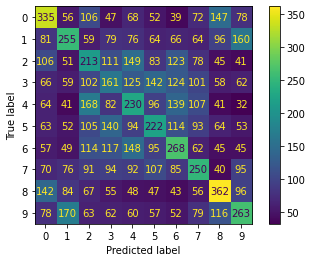

In [57]:
if __name__ == '__main__':
    main()